# Time-Between-Earthquakes

### Load the Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("usgs/earthquake-database")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ilvir\.cache\kagglehub\datasets\usgs\earthquake-database\versions\1


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import expon, kstest, probplot
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(r"C:\Users\ilvir\.cache\kagglehub\datasets\usgs\earthquake-database\versions\1\database.csv") 

df.head(10)

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic
5,01/10/1965,13:36:32,-13.405,166.629,Earthquake,35.0,NaN,NaN,6.7,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860922,ISCGEM,ISCGEM,ISCGEM,Automatic
6,01/12/1965,13:32:25,27.357,87.867,Earthquake,20.0,NaN,NaN,5.9,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM861007,ISCGEM,ISCGEM,ISCGEM,Automatic
7,01/15/1965,23:17:42,-13.309,166.212,Earthquake,35.0,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM861111,ISCGEM,ISCGEM,ISCGEM,Automatic
8,01/16/1965,11:32:37,-56.452,-27.043,Earthquake,95.0,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEMSUP861125,ISCGEMSUP,ISCGEM,ISCGEM,Automatic
9,01/17/1965,10:43:17,-24.563,178.487,Earthquake,565.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM861148,ISCGEM,ISCGEM,ISCGEM,Automatic


### Preprocess the Data

In [6]:
# Remove unused columns
df = df.drop(columns=["Depth Error", "Depth Seismic Stations", "Magnitude Type", "Magnitude Error", "Magnitude Seismic Stations",
                      "Azimuthal Gap", "Horizontal Distance", "Horizontal Error", "Root Mean Square", "ID", "Source",
                      "Location Source", "Magnitude Source", "Status"])  

In [8]:
# Filter Japan earthquakes (latitude/longitude box approx. for Japan)
japan_quakes = df[
    (df["Latitude"].between(24.0, 45.5)) & 
    (df["Longitude"].between(122.0, 146.0))
]

# Convert date/time to datetime and sort
japan_quakes = japan_quakes.copy()  # Create a copy to avoid SettingWithCopyWarning
japan_quakes["Date"] = pd.to_datetime(japan_quakes["Date"] + " " + japan_quakes["Time"], errors='coerce')
japan_quakes = japan_quakes.sort_values("Date")

# Calculate inter-arrival times in hours
japan_quakes["TimeDiff"] = japan_quakes["Date"].diff().dt.total_seconds() / 3600

japan_quakes.head()

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,TimeDiff
55,1965-02-16 12:24:10,12:24:10,38.908,142.095,Earthquake,53.5,5.7,NaN
89,1965-03-16 16:46:17,16:46:17,40.697,143.032,Earthquake,32.1,6.4,676.368611
101,1965-03-29 10:47:38,10:47:38,40.687,142.915,Earthquake,30.0,6.4,306.022500
111,1965-04-06 05:31:59,05:31:59,36.083,139.968,Earthquake,50.0,5.7,186.739167
121,1965-04-12 20:41:17,20:41:17,30.317,138.702,Earthquake,421.7,5.6,159.155000


In [10]:
inter_arrival = japan_quakes["TimeDiff"].dropna().values  # Remove NaN from the first row
inter_arrival

array([676.36861111, 306.0225    , 186.73916667, ...,  11.39444444,
       831.25388889,  55.49361111])

In [12]:
# Remove zero values for log scale and histogram
non_zero_inter_arrival = inter_arrival[inter_arrival > 0]
print(f"Number of zero inter-arrival times removed: {len(inter_arrival) - len(non_zero_inter_arrival)}")

# Estimate aftershocks (assume inter-arrival < 10 days = 24 hours indicates potential aftershocks https://www.jma.go.jp/jma/en/Activities/aftershock.html)
aftershock_threshold = 10*24  # 10 days in hours
num_aftershocks = np.sum(inter_arrival <= aftershock_threshold)
print(f"Number of potential aftershocks (inter-arrival ≤ {aftershock_threshold} hours): {num_aftershocks}")

Number of zero inter-arrival times removed: 1
Number of potential aftershocks (inter-arrival ≤ 240 hours): 1144


In [14]:
# Filter out zero inter-arrival times and aftershocks (<= 240 hours)
declustered_inter_arrival = inter_arrival[(inter_arrival > 0) & (inter_arrival > aftershock_threshold)]

# Subtract aftershock threshold from declustered inter-arrival times
declustered_inter_arrival = declustered_inter_arrival - aftershock_threshold

### Fit Exponential Distribution

The Exponential distribution models the time between earthquakes

In [18]:
# Fit Exponential distribution
lambda_hat = 1 / np.mean(declustered_inter_arrival)
print(f"Exponential: Estimated rate parameter (lambda): {lambda_hat:.6f} quakes per hour")
print(f"Exponential: Mean inter-arrival time: {1/lambda_hat:.2f} hours")

# Perform KS test for exponential fit
ks_stat_exp, p_value_exp = kstest(declustered_inter_arrival, 'expon', args=(0, 1/lambda_hat))
print(f"Exponential KS Test: Statistic={ks_stat_exp:.4f}, p-value={p_value_exp:.4f}")
if p_value_exp < 0.05:
    print("Warning: The data may not follow an exponential distribution (p < 0.05).")
    
# Generate x-range for PDF (up to 99th percentile)
x = np.linspace(0, np.percentile(declustered_inter_arrival, 99), 100)

# Compute Exponential PDF
exp_pdf = expon.pdf(x, scale=1/lambda_hat)

Exponential: Estimated rate parameter (lambda): 0.002727 quakes per hour
Exponential: Mean inter-arrival time: 366.69 hours
Exponential KS Test: Statistic=0.0383, p-value=0.3039


The Exponential model is statistically valid for this aftershock-free data, enabling reliable risk estimates for future quake timing.

**Rate of Earthquakes (λ)**:
0.0027 quakes/hour (`≈ 6.5 quakes/year`), meaning earthquakes are not rare in this filtered dataset.

**Goodness-of-Fit (KS Test)**:
- KS Statistic = 0.038 (close to 0 → `good fit`).

- p-value = 0.30 (> 0.05) → `Fail to reject H₀` (data consistent with Exponential distribution).

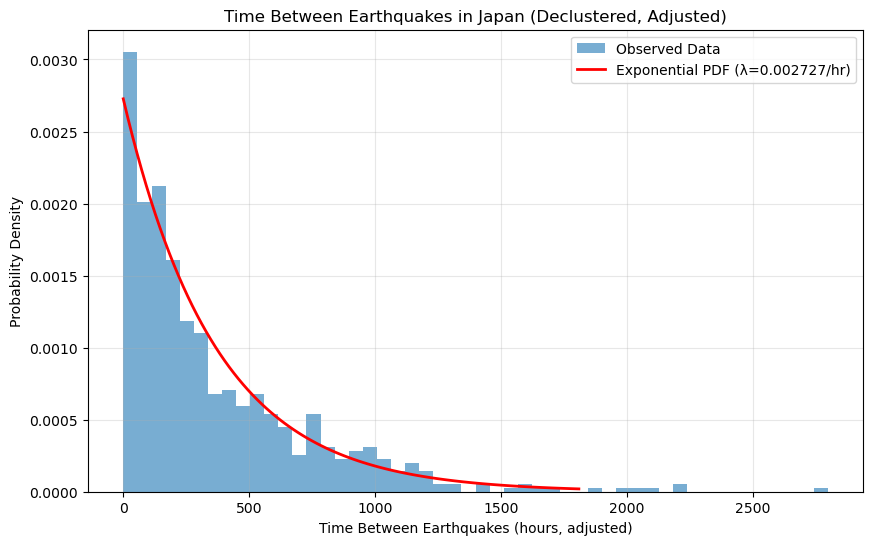

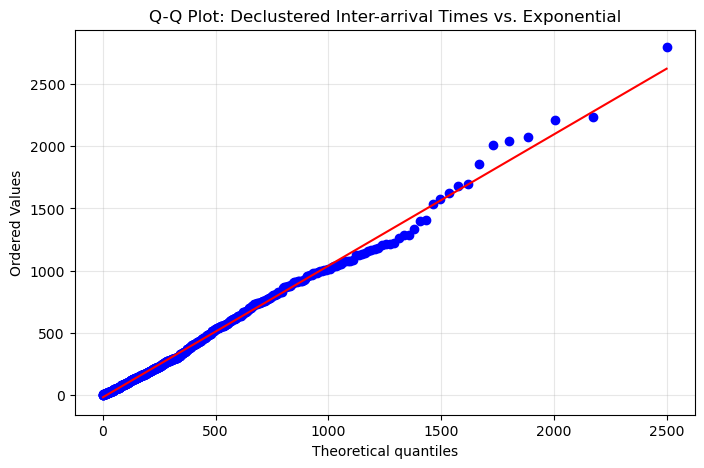

In [21]:
# Plot 1: Histogram with Exponential PDF
plt.figure(figsize=(10, 6))
plt.hist(declustered_inter_arrival, bins=50, density=True, alpha=0.6, label="Observed Data")
plt.plot(x, exp_pdf, 'r-', lw=2, label=f"Exponential PDF (λ={lambda_hat:.6f}/hr)")
plt.xlabel("Time Between Earthquakes (hours, adjusted)")
plt.ylabel("Probability Density")
plt.title("Time Between Earthquakes in Japan (Declustered, Adjusted)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: Q-Q Plot for Exponential Distribution
plt.figure(figsize=(8, 5))
probplot(declustered_inter_arrival, dist="expon", sparams=(0, 1/lambda_hat), plot=plt)
plt.title("Q-Q Plot: Declustered Inter-arrival Times vs. Exponential")
plt.grid(True, alpha=0.3)
plt.show()

- A histogram of observed times between quakes.

- A red curve showing the Exponential PDF fitted to the data.

- Q-Q plot shows the exponential fit (blue dots to red line).

### Hazard Rate Analysis

**Probability of Earthquakes in Different Time Windows:**

Probability of another quake within X hours

In [59]:
# Probability of another quake within different time windows
time_windows = [12, 24, 48, 168]  # hours
for t in time_windows:
    prob = expon.cdf(t, scale=1/lambda_hat)  
    print(f"Probability of another quake within {t} hours: {prob:.2%}")

Probability of another quake within 12 hours: 3.22%
Probability of another quake within 24 hours: 6.34%
Probability of another quake within 48 hours: 12.27%
Probability of another quake within 168 hours: 36.75%


**Earthquakes waiting time:**

What’s the Xth percentile waiting time?

In [53]:
percentiles = [0.5, 0.95, 0.99]
for p in percentiles:
    wait_time = expon.ppf(p, scale=1/lambda_hat)
    print(f"{int(p*100)}% of quakes occur within {wait_time:.1f} hours after the last one.")

50% of quakes occur within 254.2 hours after the last one.
95% of quakes occur within 1098.5 hours after the last one.
99% of quakes occur within 1688.7 hours after the last one.


**Expected Number of Earthquakes in a Time Period:**

Since the exponential distribution models a Poisson process, the rate parameter *lambda_hat* can estimate the expected number of earthquakes in a given period.

In [33]:
time_periods = [24, 360, 720]  # hours (1d, 1w, 30d)
for t in time_periods:
    expected_quakes = lambda_hat * t
    print(f"Expected number of quakes in {t} hours: {round(expected_quakes)}")

Expected number of quakes in 24 hours: 0
Expected number of quakes in 360 hours: 1
Expected number of quakes in 720 hours: 2


**Comparison by Magnitude:**

Inter-arrival times for different magnitude ranges (e.g., 5–7, ≥7) to see if stronger earthquakes have different temporal patterns.

In [47]:
magnitude_bins = [ (5, 7), (7, 10)]
for min_mag, max_mag in magnitude_bins:
    subset = japan_quakes[(japan_quakes["Magnitude"] >= min_mag) & (japan_quakes["Magnitude"] < max_mag)]
    subset_times = subset["TimeDiff"].dropna()
    subset_declustered = subset_times[(subset_times > 0) & (subset_times > aftershock_threshold)] - aftershock_threshold
    if len(subset_declustered) > 0:
        lambda_subset = 1 / np.mean(subset_declustered)
        print(f"Magnitude {min_mag}-{max_mag}: lambda={lambda_subset:.6f}/hr, mean={1/lambda_subset:.2f} hours")

Magnitude 5-7: lambda=0.002756/hr, mean=362.87 hours
Magnitude 7-10: lambda=0.002256/hr, mean=443.32 hours
